In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import warnings 
import numpy as np
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

In [2]:
df=pd.read_csv("gld_price_data.csv")

In [3]:
df.head(2)

,Date,SPX,GLD,USO,SLV,EUR/USD
0,1/2/2008,1447.160034,84.860001,78.470001,15.180,1.471692
1,1/3/2008,1447.160034,85.570000,78.370003,15.285,1.474491


In [4]:
df.shape

(2290, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     2290 non-null   object 
 1   SPX      2290 non-null   float64
 2   GLD      2290 non-null   float64
 3   USO      2290 non-null   float64
 4   SLV      2290 non-null   float64
 5   EUR/USD  2290 non-null   float64
dtypes: float64(5), object(1)
memory usage: 107.5+ KB


In [6]:
df.describe()

,SPX,GLD,USO,SLV,EUR/USD
count,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000
mean,1654.315776,122.732875,31.842221,20.084997,1.283653
std,519.111540,23.283346,19.523517,7.092566,0.131547
min,676.530029,70.000000,7.960000,8.850000,1.039047
25%,1239.874969,109.725000,14.380000,15.570000,1.171313
50%,1551.434998,120.580002,33.869999,17.268500,1.303297
75%,2073.010070,132.840004,37.827501,22.882500,1.369971
max,2872.870117,184.589996,117.480003,47.259998,1.598798


In [7]:
df.dtypes

Date        object
SPX        float64
GLD        float64
USO        float64
SLV        float64
EUR/USD    float64
dtype: object

In [8]:
df['Date']=pd.to_datetime(df['Date'])

In [9]:
df.duplicated().sum()

0

In [10]:
df.isnull().sum()

Date       0
SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype: int64

<Figure size 432x288 with 0 Axes>

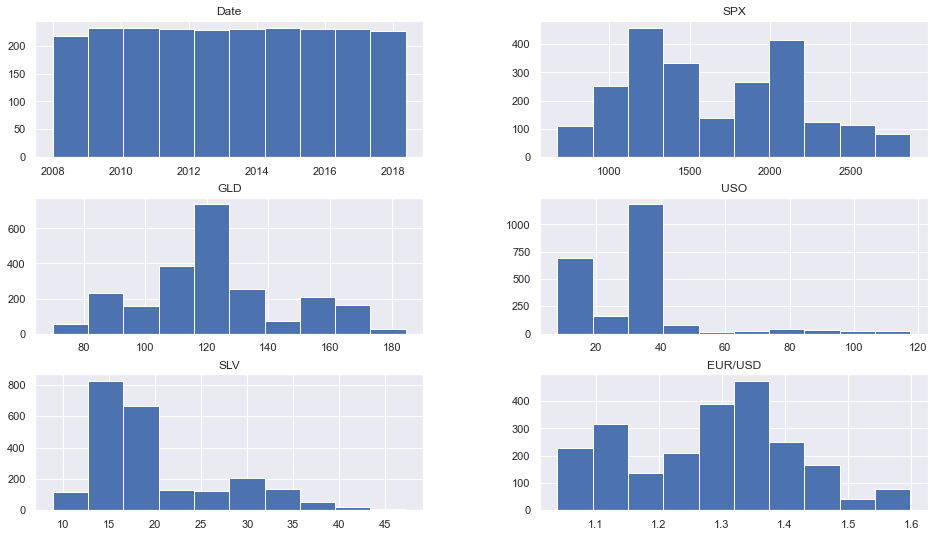

In [11]:
plt.figure()
df.hist(figsize=(16,9));

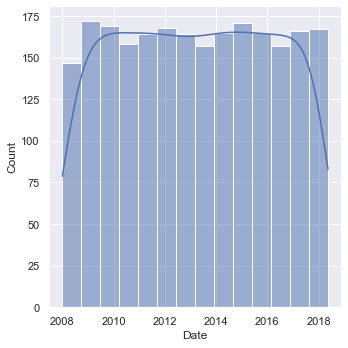

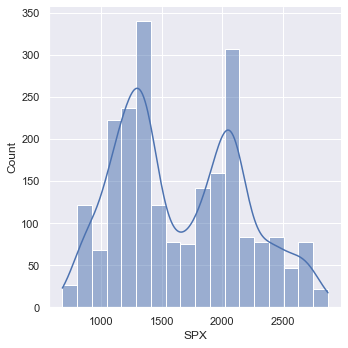

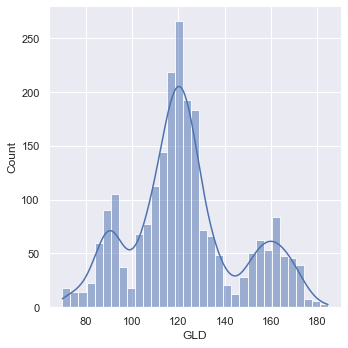

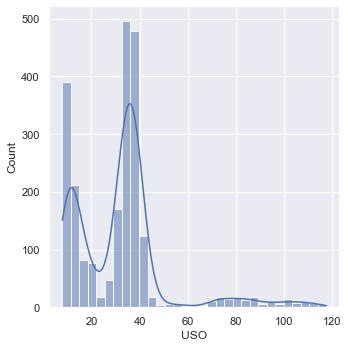

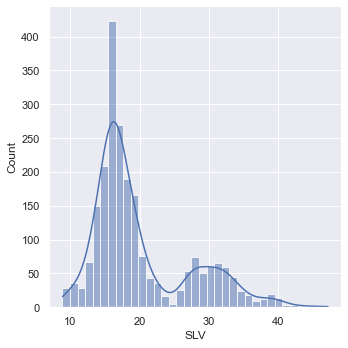

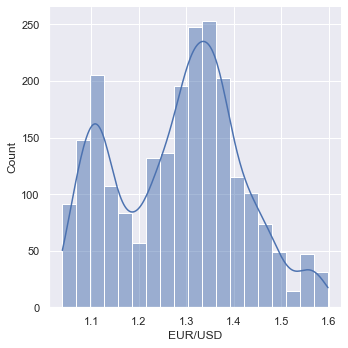

In [12]:
for col in df.columns:
    sns.displot(df[col],kde=True);

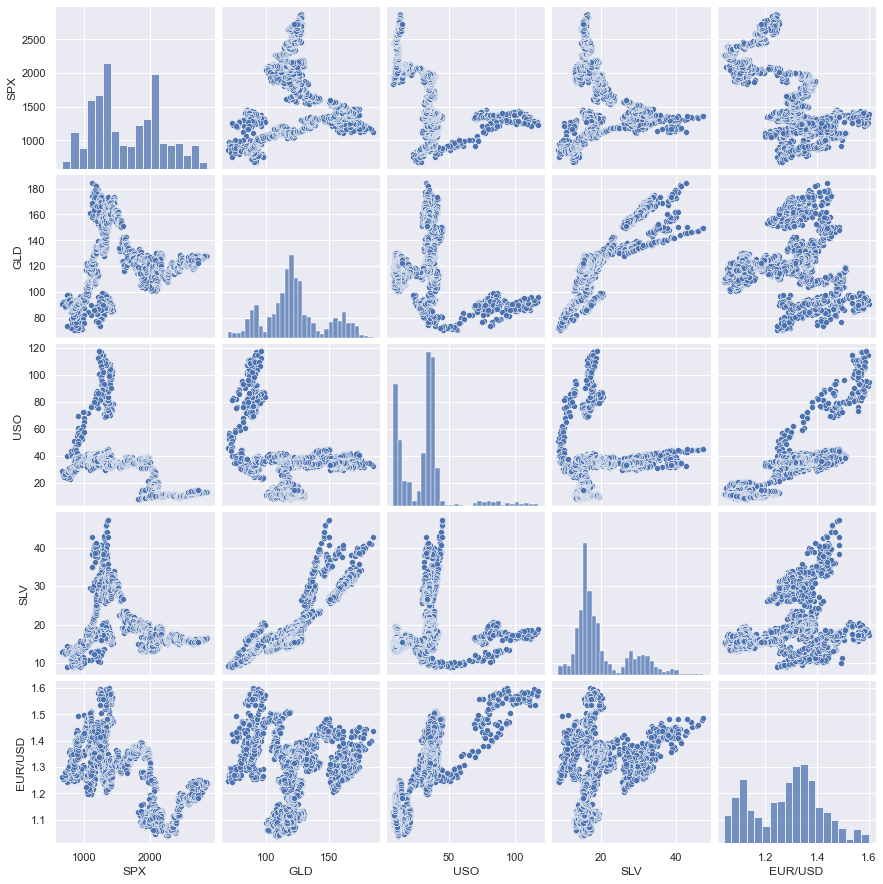

In [13]:
sns.pairplot(data=df)

<AxesSubplot:>

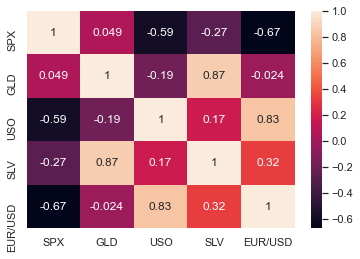

In [20]:
sns.heatmap(df.corr(),annot=True)

<AxesSubplot:>

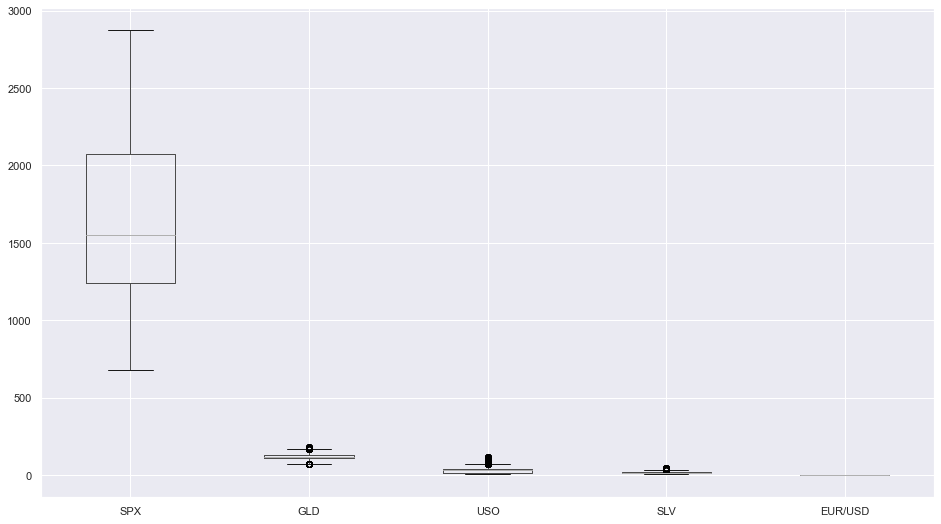

In [15]:
plt.figure(figsize=(16,9))
df.boxplot()

In [21]:
features = ['SPX', 'USO', 'SLV', 'EUR/USD']
features

['SPX', 'USO', 'SLV', 'EUR/USD']

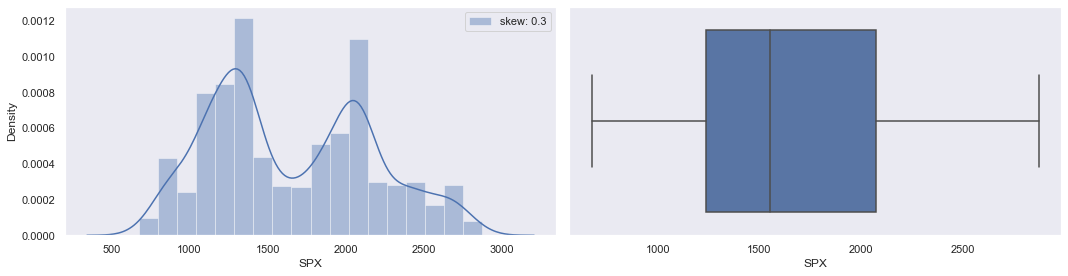

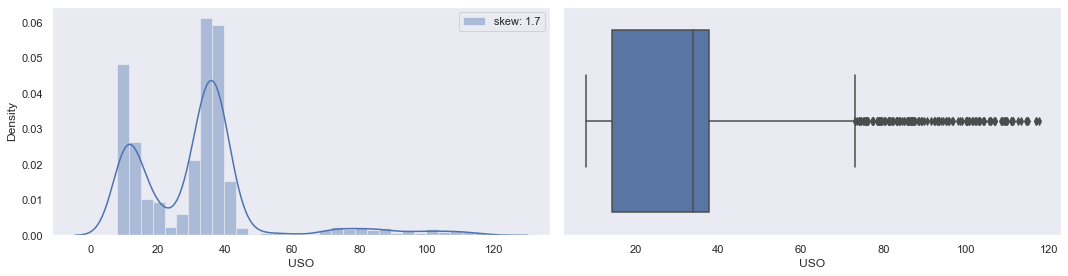

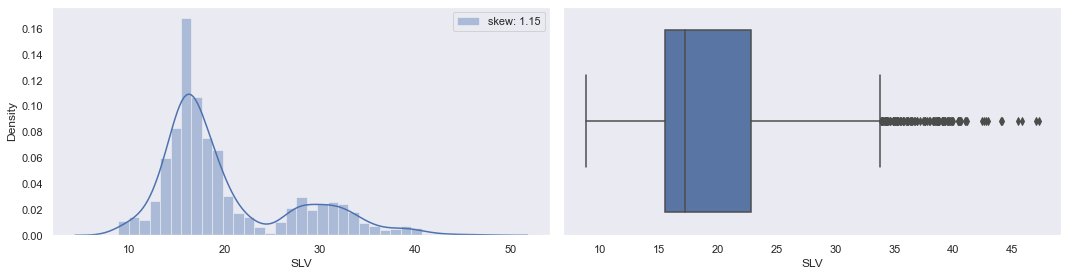

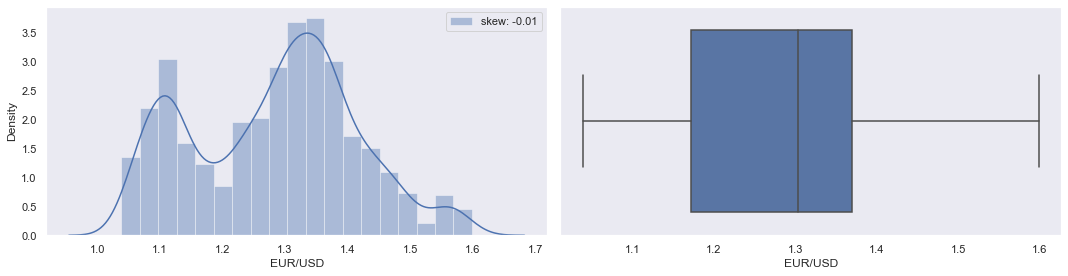

In [24]:
sns.set_style('dark')
for col in features:
    plt.figure(figsize=(15,4))
    plt.subplot(121)
    sns.distplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))
    plt.legend()
    plt.subplot(122)
    sns.boxplot(df[col])
    plt.tight_layout()
    plt.show()

In [25]:
df_cap = df.copy()

In [26]:
def iqr_capping(df, cols, factor):
    
    for col in cols:
        
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        
        iqr = q3 - q1
        
        upper_whisker = q3 + (factor*iqr)
        lower_whisker = q1 - (factor*iqr)
        
        df[col] = np.where(df[col]>upper_whisker, upper_whisker,
                 np.where(df[col]<lower_whisker, lower_whisker, df[col]))

In [27]:
iqr_capping(df_cap, features, 1.5)

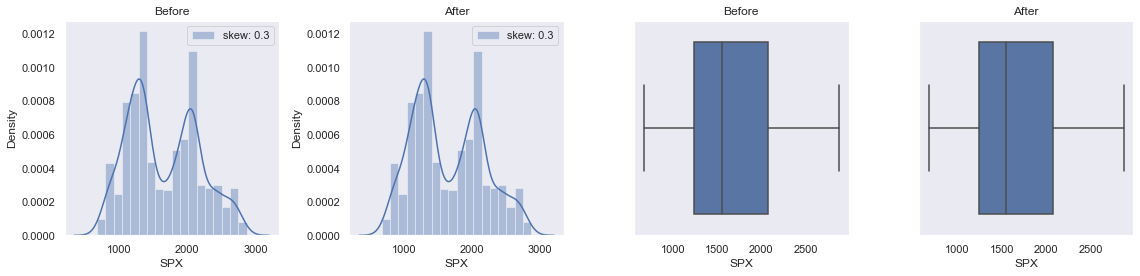

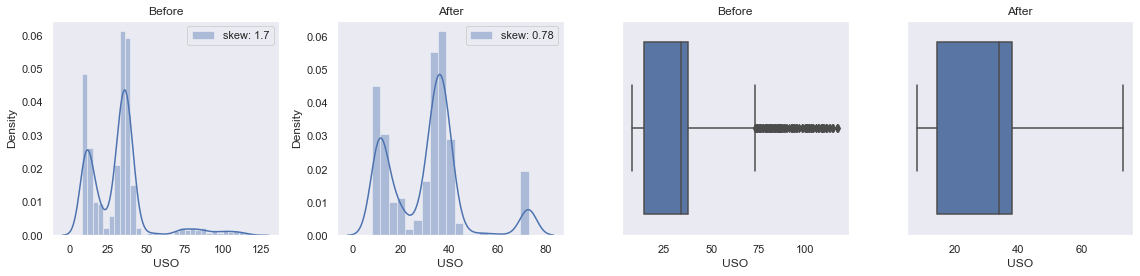

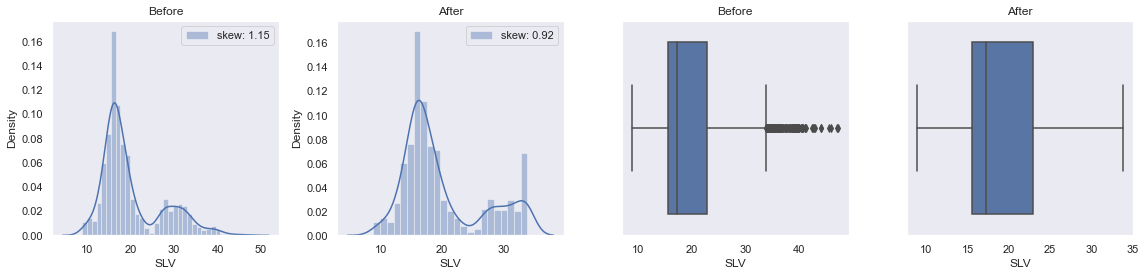

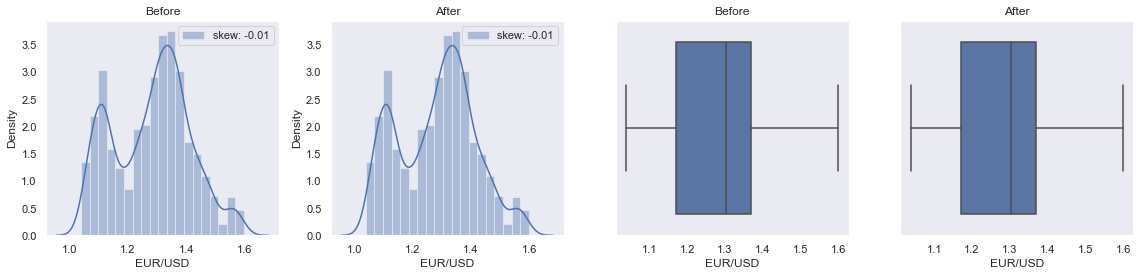

In [28]:
for col in features:
    plt.figure(figsize=(16,4))
    
    plt.subplot(141)
    sns.distplot(df[col], label="skew: " + str(np.round(df[col].skew(),2)))
    plt.title('Before')
    plt.legend()
    
    plt.subplot(142)
    sns.distplot(df_cap[col], label="skew: " + str(np.round(df_cap[col].skew(),2)))
    plt.title('After')
    plt.legend()
    
    plt.subplot(143)
    sns.boxplot(df[col])
    plt.title('Before')
    
    plt.subplot(144)
    sns.boxplot(df_cap[col])
    plt.title('After')
    plt.tight_layout()
    plt.show()

In [29]:
df_cap.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,2008-01-02,1447.160034,84.860001,72.998754,15.180,1.471692
1,2008-01-03,1447.160034,85.570000,72.998754,15.285,1.474491
2,2008-01-04,1411.630005,85.129997,72.998754,15.167,1.475492
3,2008-01-07,1416.180054,84.769997,72.998754,15.053,1.468299
4,2008-01-08,1390.189941,86.779999,72.998754,15.590,1.557099


In [16]:
X=df.drop(columns=['Date','GLD'],axis='columns')

In [18]:
X

,SPX,USO,SLV,EUR/USD
0,1447.160034,78.470001,15.1800,1.471692
1,1447.160034,78.370003,15.2850,1.474491
2,1411.630005,77.309998,15.1670,1.475492
3,1416.180054,75.500000,15.0530,1.468299
4,1390.189941,76.059998,15.5900,1.557099
...,...,...,...,...
2285,2671.919922,14.060000,15.5100,1.186789
2286,2697.790039,14.370000,15.5300,1.184722
2287,2723.070068,14.410000,15.7400,1.191753
2288,2730.129883,14.380000,15.5600,1.193118


In [17]:
y=df['GLD']

In [19]:
y

0        84.860001
1        85.570000
2        85.129997
3        84.769997
4        86.779999
           ...    
2285    124.589996
2286    124.330002
2287    125.180000
2288    124.489998
2289    122.543800
Name: GLD, Length: 2290, dtype: float64

In [20]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [21]:
rfr=RandomForestRegressor()

In [22]:
rfr.fit(X_train,y_train)

RandomForestRegressor()

In [23]:
y_train_pred=rfr.predict(X_train)

In [24]:
r2_score(y_train,y_train_pred)

0.998534226758642

In [25]:
y_test_pred=rfr.predict(X_test)

In [26]:
r2_score(y_test,y_test_pred)

0.990000697251308

In [27]:
mean_squared_error(y_test,y_test_pred)

5.482616653837803

In [28]:
mean_absolute_error(y_test,y_test_pred)

1.2345453402838455